# Custom Example

In [1]:
from backtesting.test import GOOG

In [2]:
df_GOOG = GOOG.copy()

In [3]:
df_GOOG['diff_1'] = df_GOOG.Close.diff()

In [4]:
import numpy as np

In [5]:
df_GOOG['diff_1_direction'] = np.where(df_GOOG['diff_1'] > 0, 'up', 'down')

In [6]:
df_GOOG

,Open,High,Low,Close,Volume,diff_1,diff_1_direction
2004-08-19,100.00,104.06,95.96,100.34,22351900,NaN,down
2004-08-20,101.01,109.08,100.50,108.31,11428600,7.97,up
2004-08-23,110.75,113.48,109.05,109.40,9137200,1.09,up
2004-08-24,111.24,111.60,103.57,104.87,7631300,-4.53,down
2004-08-25,104.96,108.00,103.88,106.00,4598900,1.13,up
...,...,...,...,...,...,...,...
2013-02-25,802.30,808.41,790.49,790.77,2303900,-8.94,down
2013-02-26,795.00,795.95,784.40,790.13,2202500,-0.64,down
2013-02-27,794.80,804.75,791.11,799.78,2026100,9.65,up
2013-02-28,801.10,806.99,801.03,801.20,2265800,1.42,up


i buy at the fist time the direction is up and hold until next down...

In [7]:
series_direction = df_GOOG.diff_1_direction

In [8]:
list_buy = []

In [9]:
for tomorrow_direction in series_direction:
  if tomorrow_direction == 'up':
    list_buy.append(1)
  else:
    list_buy.append(0)

In [10]:
df_GOOG['action'] = list_buy

In [11]:
df_GOOG

,Open,High,Low,Close,Volume,diff_1,diff_1_direction,action
2004-08-19,100.00,104.06,95.96,100.34,22351900,NaN,down,0
2004-08-20,101.01,109.08,100.50,108.31,11428600,7.97,up,1
2004-08-23,110.75,113.48,109.05,109.40,9137200,1.09,up,1
2004-08-24,111.24,111.60,103.57,104.87,7631300,-4.53,down,0
2004-08-25,104.96,108.00,103.88,106.00,4598900,1.13,up,1
...,...,...,...,...,...,...,...,...
2013-02-25,802.30,808.41,790.49,790.77,2303900,-8.94,down,0
2013-02-26,795.00,795.95,784.40,790.13,2202500,-0.64,down,0
2013-02-27,794.80,804.75,791.11,799.78,2026100,9.65,up,1
2013-02-28,801.10,806.99,801.03,801.20,2265800,1.42,up,1


In [12]:
list_buy = []
already_bought = False

In [13]:
for tomorrow_direction in series_direction:
  if tomorrow_direction == 'up' and already_bought == False:
    list_buy.append(1)
    already_bought = True
  elif tomorrow_direction == 'down' and already_bought == True:
    list_buy.append(1)
    already_bought = False
  else:
    list_buy.append(0)

In [14]:
df_GOOG['action_track'] = list_buy

In [23]:
df_GOOG = df_GOOG.dropna()

In [24]:
from sklearn.tree import DecisionTreeRegressor

In [25]:
model_dt = DecisionTreeRegressor()

In [48]:
df = df_GOOG[['Open','High','Low','Close','Volume', 'diff_1']]

In [49]:
target = df_GOOG.diff_1

In [50]:
explanatory = df_GOOG[['Open','High','Low','Close','Volume']]

In [51]:
model_dt.fit(explanatory, target)

DecisionTreeRegressor()

In [52]:
from backtesting import Backtest, Strategy

In [53]:
explanatory.iloc[-1:]

,Open,High,Low,Close,Volume
2013-03-01,797.8,807.14,796.15,806.19,2175400


In [54]:
model_dt.predict(explanatory)

array([ 7.97,  1.09, -4.53, ...,  9.65,  1.42,  4.99])

In [59]:
class SimpleClassification(Strategy):
  def init(self):
    self.model = model_dt

    # Prepare empty, all-NaN forecast indicator
    # self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
  def next(self):
    # Forecast the next movement
    explanatory_today = self.data.df.iloc[-1:, :-1]
    forecast_tomorrow = self.model.predict(explanatory_today)[0]
    
    print(explanatory_today)
    print(forecast_tomorrow)
    
    # self.forecasts[-1] = forecast_tomorrow
  
    self.already_bought = False
    if forecast_tomorrow > 10 and self.already_bought == False:
      self.buy()
      self.already_bought = True
    elif forecast_tomorrow < -10 and self.already_bought == True:
      self.sell()
      self.already_bought = False
      
bt = Backtest(df, SimpleClassification,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()

              Open    High     Low  Close   Volume
2004-08-23  110.75  113.48  109.05  109.4  9137200
1.0900000000000034
              Open   High     Low   Close   Volume
2004-08-24  111.24  111.6  103.57  104.87  7631300
-4.530000000000001
              Open   High     Low  Close   Volume
2004-08-25  104.96  108.0  103.88  106.0  4598900
1.1299999999999955
              Open    High     Low   Close   Volume
2004-08-26  104.95  107.95  104.66  107.91  3551000
1.9099999999999966
             Open    High     Low   Close   Volume
2004-08-27  108.1  108.62  105.69  106.15  3109000
-1.759999999999991
              Open    High     Low   Close   Volume
2004-08-30  105.28  105.49  102.01  102.01  2601000
-4.140000000000001
             Open    High     Low   Close   Volume
2004-08-31  102.3  103.71  102.16  102.37  2461400
0.35999999999999943
             Open    High    Low   Close   Volume
2004-09-01  102.7  102.97  99.67  100.25  4573700
-2.1200000000000045
             Open    High    L

In [60]:
bt.plot(filename='SimpleClassification_02.html')

Row(id='6381', ...)

In [6]:
series_GOOG = df_GOOG.Close

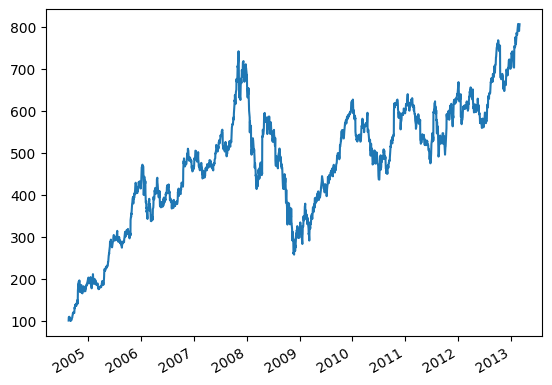

In [8]:
series_GOOG.plot();

In [10]:
series_GOOG.diff()

2004-08-19     NaN
2004-08-20    7.97
2004-08-23    1.09
2004-08-24   -4.53
2004-08-25    1.13
              ... 
2013-02-25   -8.94
2013-02-26   -0.64
2013-02-27    9.65
2013-02-28    1.42
2013-03-01    4.99
Name: Close, Length: 2148, dtype: float64